In [270]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors

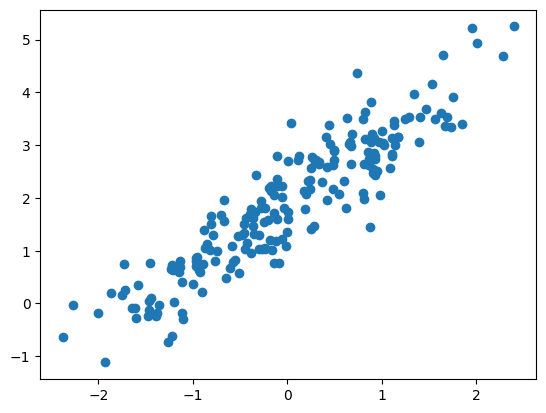

In [271]:
# simulate true model and observed data
N_observations = 200

slope = 1.2
intercept = 1.9
noise_eps = 0.5
x = np.random.normal(0,1, N_observations)#.sample(N_observations)
noise = np.random.normal(0,noise_eps, N_observations)

y = slope*x + intercept + noise

# Convert x and y to TensorFlow tensors
x = tf.convert_to_tensor(x, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

plt.scatter(x,y)

In [272]:
# Target model
model = tfd.JointDistributionSequentialAutoBatched([
    tfd.Normal(loc=1., scale=1., name='m'),   # m
    tfd.Normal(loc=1., scale=1., name='b'),   # b
    tfd.HalfNormal(scale=.7, name='eps'),        # eps
    lambda eps, b, m: tfd.Normal(loc=b*x + m, scale=eps, name='y') # Y
])

# Define target_log_prob_fn like this to remove y from the input
target_log_prob_fn = lambda m, b, eps: model.log_prob([m, b, eps, y])


# surrogate
def get_surrogate():

    return tfd.JointDistributionSequentialAutoBatched([   
     # m 
    tfd.Normal(
            loc=tf.Variable(1., name='q_m_loc'),
            scale=tfp.util.TransformedVariable(1., bijector=tfb.Softplus(), name='q_m_scale'), name='q_m'),
    # b
    tfd.Normal(
            loc=tf.Variable(1., name='q_b_loc'),
            scale=tfp.util.TransformedVariable(1., bijector=tfb.Softplus(), name='q_b_scale'), name='q_b'),
    #tfd.HalfNormal(
    #        scale=tfp.util.TransformedVariable(1., bijector=tfb.Softplus(), name='q_b_scale'), name='q_b'),
    # eps
    tfd.LogNormal(
            loc=tf.Variable(0.1, name='q_eps_loc'),
            scale=tfp.util.TransformedVariable(.5, bijector=tfb.Softplus(), name='q_eps_scale'), name='q_eps'),
    #tfd.HalfNormal(
    #        scale=tfp.util.TransformedVariable(0.3, bijector=tfb.Softplus(), name='q_eps_scale'), name='q_eps')
])

surrogate = get_surrogate()

print('Trainable variables. Surrogate')
for i, v in enumerate(surrogate.trainable_variables):
    print(i, ':', v)


print('\nmodel graph')
print(model.resolve_graph())

print('\nsurrogate graph')
print(surrogate.resolve_graph())

print('Examples log probs (sample)')
sample = surrogate.sample(5)
for i in sample:
    print(i)
#print(target_log_prob_fn(*sample[::-1]).numpy())
print(target_log_prob_fn(*sample).numpy())
print(surrogate.log_prob(*sample).numpy())

Trainable variables. Surrogate
0 : <tf.Variable 'q_m_loc:0' shape=() dtype=float32, numpy=1.0>
1 : <tf.Variable 'q_m_scale:0' shape=() dtype=float32, numpy=0.54132485>
2 : <tf.Variable 'q_b_loc:0' shape=() dtype=float32, numpy=1.0>
3 : <tf.Variable 'q_b_scale:0' shape=() dtype=float32, numpy=0.54132485>
4 : <tf.Variable 'q_eps_loc:0' shape=() dtype=float32, numpy=0.1>
5 : <tf.Variable 'q_eps_scale:0' shape=() dtype=float32, numpy=-0.43275213>

model graph
(('m', ()), ('b', ()), ('eps', ()), ('y', ('eps', 'b', 'm')))

surrogate graph
(('q_m', ()), ('q_b', ()), ('q_eps', ()))
Examples log probs (sample)
tf.Tensor([ 1.0272796  -0.20466661  1.4045122   0.5859616   0.84648144], shape=(5,), dtype=float32)
tf.Tensor([1.7647759  0.10584009 0.6515994  2.0716252  1.0852556 ], shape=(5,), dtype=float32)
tf.Tensor([0.45533156 1.8897275  0.49997345 1.4886976  0.5329784 ], shape=(5,), dtype=float32)
[-667.46277 -480.94424 -357.15884 -390.16675 -542.80945]
[-3.1423302 -4.4009924 -2.771308  -3.298965 

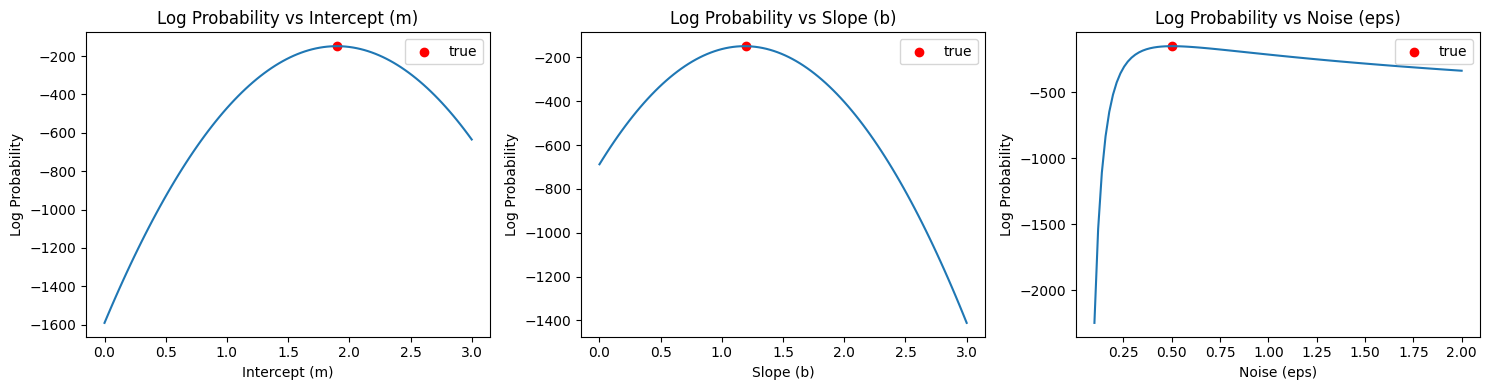

In [273]:
# Test to verify the logprob. create a marginal plot over each parameters logprob given the other params have the true value.
if True:
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    # Intercept (m) plot
    m_linspace = np.linspace(0, 3, 100)
    logprobs_m = [target_log_prob_fn(m_i, slope, noise_eps) for m_i in m_linspace]

    axs[0].plot(m_linspace, logprobs_m)
    axs[0].scatter(intercept, target_log_prob_fn(intercept, slope, noise_eps), color='red', label='true')
    axs[0].set_xlabel("Intercept (m)")
    axs[0].set_ylabel("Log Probability")
    axs[0].legend()
    axs[0].set_title("Log Probability vs Intercept (m)")

    # Slope (b) plot
    b_linspace = np.linspace(0, 3, 100)
    logprobs_b = [target_log_prob_fn(intercept, b_i, noise_eps) for b_i in b_linspace]

    axs[1].plot(b_linspace, logprobs_b)
    axs[1].scatter(slope, target_log_prob_fn(intercept, slope, noise_eps), color='red', label='true')
    axs[1].set_xlabel("Slope (b)")
    axs[1].set_ylabel("Log Probability")
    axs[1].legend()
    axs[1].set_title("Log Probability vs Slope (b)")

    # Noise (eps) plot
    eps_linspace = np.linspace(0.1, 2, 100)
    logprobs_eps = [target_log_prob_fn(intercept, slope, eps_i) for eps_i in eps_linspace]

    axs[2].plot(eps_linspace, logprobs_eps)
    axs[2].scatter(noise_eps, target_log_prob_fn(intercept, slope, noise_eps), color='red', label='true')
    axs[2].set_xlabel("Noise (eps)")
    axs[2].set_ylabel("Log Probability")
    axs[2].legend()
    axs[2].set_title("Log Probability vs Noise (eps)")

    plt.tight_layout()
    plt.show()

## using fit_surrogate_posterior

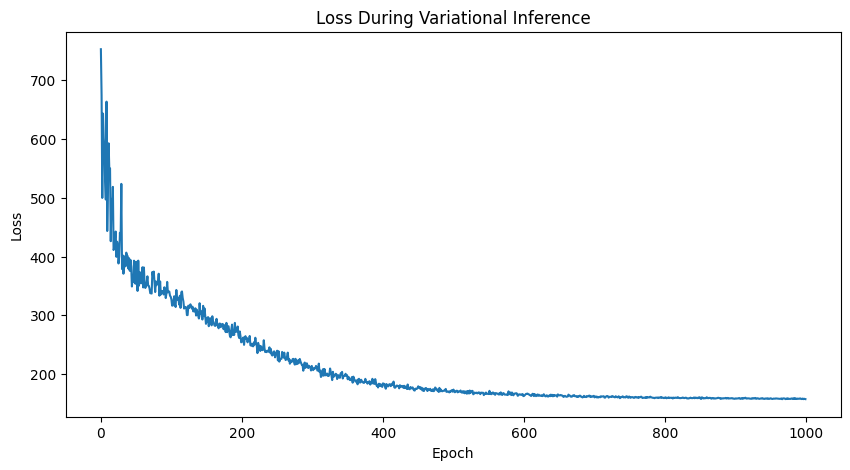

In [274]:
num_steps = 1000
sample_size = 64
learning_rate = 0.01

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=target_log_prob_fn,
    surrogate_posterior=surrogate,
    optimizer=optimizer,
    num_steps=num_steps,
    sample_size=sample_size
)

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss During Variational Inference")
plt.show()

In [275]:
[m, b, eps] = np.mean(surrogate.sample(1000), axis=1)
print(m, b , eps)

1.8938655 1.1825205 0.52000195


In [276]:
print('True params')
print('intercept', intercept)
print('slope', slope)
print('noise_eps', noise_eps)

True params
intercept 1.9
slope 1.2
noise_eps 0.5


## custom elbo and gradients

**Why is this considerably slower?**

In [305]:
surrogate_alt = get_surrogate() 

SUM_ELSE_MEAN = False

def elbo(target_log_prob_fn, surrogate, sample_size=32, sum_else_mean:bool=SUM_ELSE_MEAN):
    """
    ELBO(q) = E_q[log p(x, z)] - E_q[log q(z)]
    
    If your data is divided into batches and you're updating your model parameters batch-by-batch (mini-batch learning), then you might want to use tf.reduce_sum instead.
    """
    samples = surrogate.sample(sample_size)
    if sum_else_mean:
        elbo_ = tf.reduce_sum(target_log_prob_fn(*samples)) - tf.reduce_sum(surrogate.log_prob(*samples))
    else:
        elbo_ = tf.reduce_mean(target_log_prob_fn(*samples)) - tf.reduce_mean(surrogate.log_prob(*samples))
    return elbo_

def elbo_loss(target_log_prob_fn, surrogate, sample_size=32, sum_else_mean:bool=SUM_ELSE_MEAN):
    return -elbo(target_log_prob_fn, surrogate, sample_size, sum_else_mean)

print('Elbo:', elbo(target_log_prob_fn, surrogate_alt, 2, True))
print('Elbo:', elbo(target_log_prob_fn, surrogate_alt, 2, False))


Elbo: tf.Tensor(-971.3083, shape=(), dtype=float32)
Elbo: tf.Tensor(-497.49933, shape=(), dtype=float32)


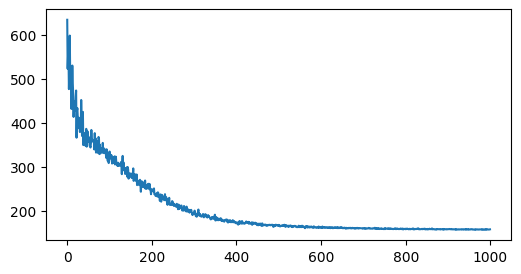

In [306]:
num_steps = 1000
sample_size = 64
learning_rate = 0.01
sum_else_mean = False

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
trainable_variables = surrogate_alt.trainable_variables

losses = []
for step in range(num_steps):
    with tf.GradientTape() as tape:
        loss = elbo_loss(target_log_prob_fn, surrogate_alt, sample_size=sample_size, sum_else_mean=sum_else_mean)
    grads = tape.gradient(loss, trainable_variables) 
    optimizer.apply_gradients(zip(grads, trainable_variables))  # update the parameters using the gradients
    losses.append(loss)

plt.figure(figsize=(6, 3))
plt.plot(losses)
plt.show()


In [310]:
[m, b, eps] = np.mean(surrogate_alt.sample(1000), axis=1)
print(m, b , eps)

1.899586 1.1851575 0.5145304


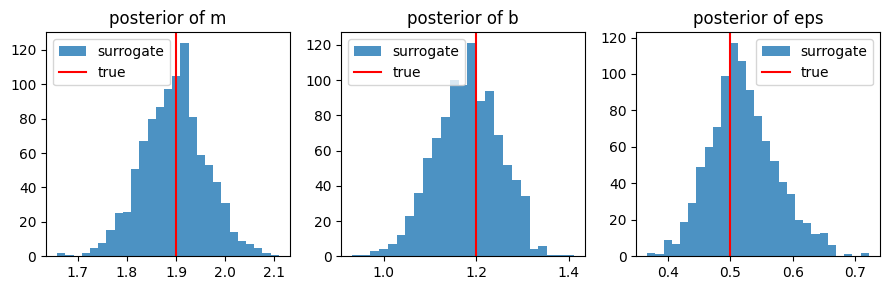

In [309]:

samples = surrogate.sample(1000)


plt.figure(figsize=(9, 3))
for i, param in enumerate(['m', 'b', 'eps']):
    plt.subplot(1, 3, i+1)
    plt.hist(samples[i].numpy(), bins='auto', alpha=0.8, label='surrogate')
    plt.axvline([intercept, slope, noise_eps][i], color='red', label='true')
    plt.title(f'posterior of {param}')
    plt.legend()
plt.tight_layout()
plt.show()
 

# Predictions

In [285]:
x_test = np.random.normal(0,1, 5)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)

In [286]:
# Alternative 1 : means of the surrogate posterior distributions to make predictions is a form of point estimation
[m, b, eps] = np.mean(surrogate.sample(1000), axis=1)

prediction_model = tfd.Normal(loc=b*x_test + m, scale=eps)

point_preds = prediction_model.sample()
print(point_preds)


tf.Tensor([2.9480577 4.947508  2.057972  2.8342137 2.1326468], shape=(5,), dtype=float32)


In [287]:
# Alt 1.b

pe_preds_deterministic = b*x_test + m
noise = tf.random.normal(shape=x_test.shape, mean=0., stddev=eps)
pe_preds_w_noise = pe_preds_deterministic + noise

print(pe_preds_deterministic)
print(pe_preds_w_noise)

tf.Tensor([2.4467838 5.230353  1.5819526 2.318932  2.7264788], shape=(5,), dtype=float32)
tf.Tensor([2.7457304 5.970309  2.3707154 2.1639802 2.671354 ], shape=(5,), dtype=float32)


In [288]:
# Alt 2.
n_samples = 1000
samples = surrogate.sample(n_samples)

m_samples = tf.reshape(samples[0], [n_samples, 1])
b_samples = tf.reshape(samples[1], [n_samples, 1])
eps_samples = tf.reshape(samples[2], [n_samples, 1])


prediction_model = tfd.Normal(loc=b_samples*x_test + m_samples, scale=eps_samples)

preds = prediction_model.sample()

mean_preds = tf.reduce_mean(preds, axis=0)
stddev_prediction = tf.math.reduce_std(preds, axis=0)

In [289]:
mean_preds

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([2.4704547, 5.2151003, 1.5864776, 2.3309371, 2.7213922],
      dtype=float32)>

In [290]:
stddev_prediction

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.5164961 , 0.56422824, 0.52352107, 0.5223108 , 0.52742785],
      dtype=float32)>

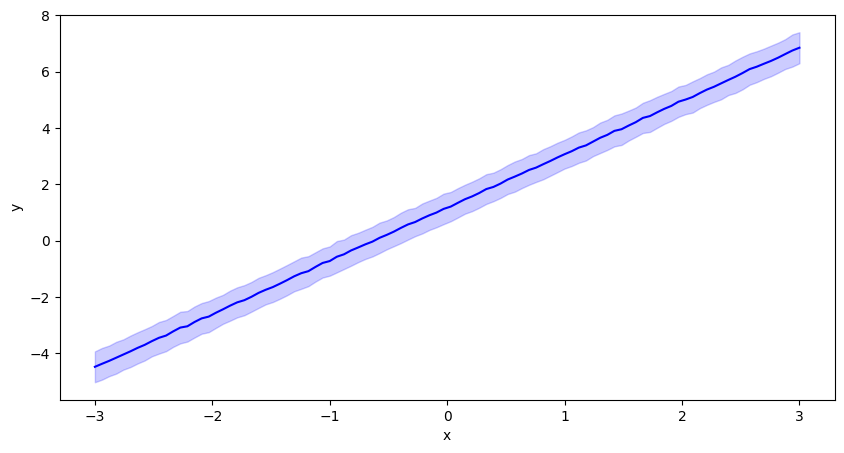

In [313]:
x_ls = np.linspace(-3,3,100)
x_ls = tf.convert_to_tensor(x_ls, dtype=tf.float32)


n_samples = 1000
samples = surrogate.sample(n_samples)

m_samples = tf.reshape(samples[0], [n_samples, 1])
b_samples = tf.reshape(samples[1], [n_samples, 1])
eps_samples = tf.reshape(samples[2], [n_samples, 1])

x_test = tf.reshape(x_ls, [1, -1])
prediction_model = tfd.Normal(loc=b_samples + m_samples * x_test, scale=eps_samples)

preds = prediction_model.sample()

mean_preds = tf.reduce_mean(preds, axis=0)
stddev_preds = tf.math.reduce_std(preds, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(x_ls, mean_preds, color='blue')
plt.fill_between(x_ls, mean_preds - stddev_preds, mean_preds + stddev_preds, color='blue', alpha=0.2)
plt.fill_between(x_ls, mean_preds - np.mean, mean_preds + stddev_preds, color='blue', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [318]:
print('std preds', np.mean(stddev_preds))

print('eps (noise)', np.mean(eps_samples))

std preds 0.5360116
eps (noise) 0.5197823
